# Minimal working example scripts (made to be tested in Yale's cluster)

Here you can find a set of scripts oriented to test the MWE with different pipelines (e.g `LMM.ipynb`, `Hudson_plot.ipynb`, etc).

If you have a local copy of the MWE please make sure to change the paths before running the script. 

Also, it is very important to select the appopiate kernel, in this case you would need to select bash on the drop-down menu to the right of the script

*Note:* to test the LD-clumping and Hudson_plot pipelines you would need to have run the LMM.ipynb beforehand and obtain the summary statistics file (pre-requisite for the mentioned pipelines). 

These scripts are designed to run in Yale's cluster. If you need to run them in your local computer make sure you add the correct paths and remove both --container_lmm and --container_marp options

For more information on each pipeline please take a look at each notebook

If you find that instructions are confusing, please take note on how to improve and send them Diana Cornejo. Thanks for your suggestions.

Update: 02-11-2020 Added scripts for PLINK binary files (FIXME: manhattan plot complaining about non-existent ylim object)

In [1]:
# Global
MWE_PATH=/gpfs/gibbs/pi/dewan/data/UKBiobank/MWE
UKBB_PATH=/gpfs/gibbs/pi/dewan/data/UKBiobank
container_lmm=/gpfs/gibbs/pi/dewan/data/UKBiobank/lmm.sif
container_marp=/gpfs/gibbs/pi/dewan/data/UKBiobank/marp.sif 
bfile=$MWE_PATH/genotypes.bed
formatFile_fastGWA=$MWE_PATH/fastGWA_template.yml
formatFile_regenie=$MWE_PATH/regenie_template.yml
formatFile_boltlmm=$MWE_PATH/boltLMM_template.yml

# Inputed data
cwd=$MWE_PATH/output
sampleFile=$MWE_PATH/imputed_genotypes.sample
genoFile=$MWE_PATH/imputed_genotypes_chr*.bgen
phenoFile=$MWE_PATH/phenotypes.txt
sumstatsFiles=$MWE_PATH/output/phenotypes_BMI.fastGWA.snp_stats.gz
region_file=$MWE_PATH/regions.txt
bgen_sample_path=$MWE_PATH/imputed_genotypes.sample


# Exome data
#cwd=$MWE_PATH/output
#sampleFile=$MWE_PATH/burden/ukb23155_c21_b0_v1.plink.exome.filtered.fam
#genoFile=$MWE_PATH/burden/ukb23155_c2*_b0_v1.plink.exome.filtered.bed
#phenoFile=$MWE_PATH/burden/phenotype_burden.txt
#sumstatsFiles=$MWE_PATH/output/burden/phenotype_burden_BMI.fastGWA.snp_stats.gz
#sumstatsFiles=$MWE_PATH/output/burden/phenotype_burden_ASTHMA.regenie.snp_stats.gz
unrelated_samples=$MWE_PATH/burden/unrelated_ind_burden.txt
region_file=$MWE_PATH/regions_plink.txt
geno_path=$MWE_PATH/burden/genotype_inventory_bed.txt
bgen_sample_path=$MWE_PATH/

## Create MWE for regenie_burden and region_extraction

In [ ]:
sos run ~/project/UKBB_GWAS_dev/workflow/MWE.ipynb plink_mwe\
    --cwd $MWE_PATH/burden \
    --bfile $UKBB_PATH/genotype_files/pleiotropy_geneticfiles/UKB_Caucasians_phenotypeindepqc120319_updated020720removedwithdrawnindivs.bed \
    --genoFile `echo $UKBB_PATH/genotype_files/ukb28374_exomedata/exome_data_OCT2020/ukb23155_c{21..22}_b0_v1.bed` \
    --sampleFile $MWE_PATH/imputed_genotypes.sample \
    --phenoFile $MWE_PATH/burden/phenotype_burden.txt \
    --samplesPlink $MWE_PATH/burden/phenotype_burden_IID.txt \
    --unrelated_samples $MWE_PATH/burden/unrelated_ind_burden.txt \
    --rsid `echo ~/scratch60/plink-clumping/chr{21..22}_filter_snps.txt`

In [ ]:
sos dryrun ~/project/UKBB_GWAS_dev/workflow/MWE.ipynb plink_mwe \
    --cwd ~/scratch60/plink-clumping/MWE \
    --bfile /gpfs/gibbs/pi/dewan/data/UKBiobank/genotype_files/pleiotropy_geneticfiles/UKB_Caucasians_phenotypeindepqc120319_updated082020removedwithdrawnindiv.bed \
    --genoFile `echo /gpfs/gibbs/pi/dewan/data/UKBiobank/genotype_files/ukb28374_exomedata/exome_data_OCT2020/ukb23155_c{21..22}_b0_v1.bed` \
    --sampleFile /gpfs/gibbs/pi/dewan/data/UKBiobank/genotype_files/ukb39554_imputeddataset/ukb32285_imputedindiv.sample \
    --samplesPlink /gpfs/gibbs/pi/dewan/data/UKBiobank/MWE/burden/phenotype_burden_IID.txt \
    --phenoFile /gpfs/gibbs/pi/dewan/data/UKBiobank/MWE/burden/phenotype_burden.txt \
    --unrelated_samples /gpfs/gibbs/pi/dewan/data/UKBiobank/genotype_files/pleiotropy_geneticfiles/unrelated_n307259/UKB_unrelatedcauc_phenotypes_asthmat2dbmiwaisthip_agesex_waisthipratio_040620 \
    -s build 

## 1. MWE for BOLT-LMM

In [ ]:
sos run ~/project/bioworkflows/GWAS/LMM.ipynb boltlmm \
    --cwd $cwd \
    --bfile $bfile\
    --sampleFile $sampleFile \
    --genoFile $genoFile \
    --phenoFile $phenoFile\
    --formatFile $formatFile_boltlmm \
    --LDscoresFile $UKBB_PATH/LDSCORE.1000G_EUR.tab.gz \
    --geneticMapFile $UKBB_PATH/genetic_map_hg19_withX.txt.gz \
    --phenoCol BMI \
    --covarCol SEX \
    --covarMaxLevels 10 \
    --qCovarCol AGE \
    --numThreads 5 \
    --bgenMinMAF 0.001 \
    --bgenMinINFO 0.1 \
    --lmm-option \
    --p_filter 1 \
    --container_lmm $container_lmm \
    --container_marp $container_marp

## 2. MWE for FastGWA

In [ ]:
sos run ~/project/bioworkflows/GWAS/LMM.ipynb fastGWA \
    --cwd $cwd \
    --bfile $bfile \
    --sampleFile $sampleFile \
    --genoFile $genoFile \
    --phenoFile $phenoFile \
    --formatFile $formatFile_fastGWA \
    --phenoCol BMI \
    --covarCol SEX \
    --qCovarCol AGE \
    --numThreads 1 \
    --bgenMinMAF 0.1 \
    --bgenMinINFO 0.1 \
    --parts 2 \
    --p_filter 1 \
    --container_lmm $container_lmm \
    --container_marp $container_marp

## 3. MWE for REGENIE

In [ ]:
sos run ~/project/bioworkflows/GWAS/LMM.ipynb regenie \
    --cwd $MWE_PATH/output/\
    --bfile $MWE_PATH/genotypes21_22.bed \
    --sampleFile $sampleFile \
    --genoFile $genoFile \
    --phenoFile $phenoFile\
    --formatFile $formatFile_regenie\
    --phenoCol ASTHMA \
    --covarCol SEX \
    --qCovarCol AGE \
    --numThreads 8 \
    --bsize 1000 \
    --lowmem_prefix $cwd\
    --trait bt \
    --minMAC 4 \
    --bgenMinMAF 0.05 \
    --bgenMinINFO 0.8 \
    --maf_filter  0.5 \
    --geno_filter  0.1 \
    --mind_filter  0.1 \
    --reverse_log_p \
    --p_filter 1\
    --container_lmm $container_lmm\
    --container_marp $container_marp

### Regenie burden

In [ ]:
anno_file = path
set_list = path
keep_gene = path
aaf_file = path
mask_file = path
aaf_bins = 0.001

sos run ~/project/bioworkflows/GWAS/LMM.ipynb regenie_burden \
    --cwd $cwd \
    --bfile $bfile\
    --sampleFile $sampleFile \
    --genoFile $genoFile\
    --phenoFile $phenoFile \
    --formatFile $formatFile_regenie\
    --phenoCol ASTHMA \
    --covarCol SEX \
    --qCovarCol AGE \
    --numThreads 8 \
    --bsize 1000 \
    --lowmem_prefix $cwd \
    --trait bt \
    --anno_file \
    --set_list $set_list \
    --keep_gene $keep_gene \
    --aaf_file $aaf_file \
    --mask_file $mask_file \
    --aaf_bins 0.1 \
    --container_lmm $container_lmm


## 4. MWE LD Clumping

In [ ]:
#%save MWE_ldclump.sh -f

# Defining bash variables for the different paths,

ld_sample_size=100
clump_field=P
clump_p1=0.001
clump_p2=1
clump_r2=0.2
clump_kb=1000
clump_annotate=OR
numThreads=20
job_size=1

#Running the workflow for BMI trait

sos run ~/project/bioworkflows/GWAS/LD_Clumping.ipynb \
    --cwd $cwd \
    --bfile $bfile \
    --genoFile $genoFile \
    --sampleFile $sampleFile \
    --sumstatsFiles $sumstatsFiles \
    --unrelated_samples $unrelated_samples \
    --ld_sample_size $ld_sample_size \
    --clump_field $clump_field \
    --clump_p1 $clump_p1 \
    --clump_p2 $clump_p2 \
    --clump_r2 $clump_r2 \
    --clump_kb $clump_kb \
    --clump_annotate $clump_annotate \
    --numThreads $numThreads \
    --job_size $job_size \
    --container_lmm $container_lmm

## 5. MWE for Hudson plot

In [ ]:
sos run ~/bioworkflows/GWAS/Hudson_plot.ipynb hudson  \
    --cwd $cwd \
    --sumstats_1 $cwd/phenotypes_WAIST.fastGWA.snp_stats.gz \
    --sumstats_2 $cwd/phenotypes_BMI.fastGWA.snp_stats.gz \
    --toptitle Waist \
    --bottomtitle BMI \
    --highlight_p_top 0.1 \
    --highlight_p_bottom 0.1 \
    --pval_filter 1 \
    --container_lmm  $container_lmm

## Example of the Hudson_plot.ipynb in real UK Biobank data

In [ ]:
sos run ~/bioworkflows/GWAS/Hudson_plot.ipynb hudson \
    --cwd $cwd \
    --sumstats_1 $UKBB_PATH/results/FastGWA_results/results_imputed_data/tinnitus_082720/200811_UKBB_Tinnitus_plan1_2_3_f4803_tinnitus.fastGWA.snp_stats.gz \
    --sumstats_2 $UKBB_PATH/results/FastGWA_results/results_imputed_data/tinnitus_p2_082720/200811_UKBB_Tinnitus_plan1_2_3_f4803_tinnitus_p2.fastGWA.snp_stats.gz \
    --toptitle Tinnitus plan1 \
    --bottomtitle Tinnitus plan2 \
    --highlight_p_top 5e-08 \
    --highlight_p_bottom 5e-08 \
    --pval_filter 5e-08 \
    --container_lmm $container_lmm

In [ ]:
%preview -s png ~/output/200811_UKBB_Tinnitus_plan1_2_3_f4803_tinnitus.fastGWA_200811_UKBB_Tinnitus_plan1_2_3_f4803_tinnitus_p2.fastGWA.hudson.png

## 6. MWE annotation

### Merge bim files

In [ ]:
bedfiles=`echo /gpfs/gibbs/pi/dewan/data/UKBiobank/genotype_files/ukb28374_exomedata/exome_data_OCT2020/ukb23155_c{1..22}_b0_v1.bed`
bimfiles=`echo /gpfs/gibbs/pi/dewan/data/UKBiobank/genotype_files/ukb28374_exomedata/exome_data_OCT2020/ukb23155_c{1..22}_b0_v1.bim`
bim_name=~/scratch60/output/ukb23155_chr1_chr22.bim
humandb=/gpfs/ysm/datasets/db/annovar/humandb
name_prefix=rare_variants
maf_filter=0.0
max_maf_filter=0.001
geno_filter=0.0
hwe_filter=0.0
mind_filter=0.0

sos run ~/project/UKBB_GWAS_dev/workflow/QC_Exome_UKBB.ipynb bim_merge \
    --cwd ~/output \
    --bedfiles $bedfiles\
    --bimfiles $bimfiles \
    --bim_name $bim_name \
    --name_prefix $name_prefix\
    --maf_filter  $maf_filter \
    --max_maf_filter $max_maf_filter\
    --geno_filter $geno_filter \
    --mind_filter  $mind_filter \
    --humandb $humandb\
    --container_lmm $container_lmm

### Filter variants to annotate

In [ ]:
bedfiles=`echo /gpfs/gibbs/pi/dewan/data/UKBiobank/genotype_files/ukb28374_exomedata/exome_data_OCT2020/ukb23155_c22_b0_v1.bed`
bimfiles=`echo /gpfs/gibbs/pi/dewan/data/UKBiobank/genotype_files/ukb28374_exomedata/exome_data_OCT2020/ukb23155_c{1..22}_b0_v1.bim`
bim_name=/home/dc2325/scratch60/output/ukb23155_chr1_chr3.bim
name_prefix=rare_variants
maf_filter=0.0
max_maf_filter=0.001
geno_filter=0.0
hwe_filter=0.0
mind_filter=0.0
sos run ~/project/UKBB_GWAS_dev/workflow/QC_Exome_UKBB.ipynb get_snps \
    --cwd /home/dc2325/scratch60/output/ \
    --bedfiles $bedfiles\
    --bimfiles $bimfiles \
    --bim_name $bim_name \
    --name_prefix $name_prefix\
    --maf_filter  $maf_filter \
    --max_maf_filter $max_maf_filter\
    --geno_filter $geno_filter \
    --mind_filter  $mind_filter \
    --container_lmm /gpfs/gibbs/pi/dewan/data/UKBiobank/lmm.sif

### Convert to vcf if needed

In [ ]:
bedfiles=`echo /gpfs/gibbs/pi/dewan/data/UKBiobank/genotype_files/ukb28374_exomedata/exome_data_OCT2020/ukb23155_c22_b0_v1.bed`
bimfiles=`echo /gpfs/gibbs/pi/dewan/data/UKBiobank/genotype_files/ukb28374_exomedata/exome_data_OCT2020/ukb23155_c{1..22}_b0_v1.bim`
bim_name=/home/dc2325/scratch60/output/ukb23155_chr1_chr3.bim
name_prefix=rare_variants
maf_filter=0.0
max_maf_filter=0.001
geno_filter=0.0
hwe_filter=0.0
mind_filter=0.0
sos run ~/project/UKBB_GWAS_dev/workflow/QC_Exome_UKBB.ipynb convert_to_vcf \
    --cwd /home/dc2325/scratch60/output/ \
    --bedfiles $bedfiles\
    --bimfiles $bimfiles \
    --bim_name $bim_name \
    --name_prefix $name_prefix\
    --maf_filter  $maf_filter \
    --max_maf_filter $max_maf_filter\
    --geno_filter $geno_filter \
    --mind_filter  $mind_filter \
    --container_lmm /gpfs/gibbs/pi/dewan/data/UKBiobank/lmm.sif

### Annotate functional variation

In [ ]:
bedfiles=`echo /gpfs/gibbs/pi/dewan/data/UKBiobank/genotype_files/ukb28374_exomedata/exome_data_OCT2020/ukb23155_c{1..3}_b0_v1.bed`
bimfiles=`echo /gpfs/gibbs/pi/dewan/data/UKBiobank/genotype_files/ukb28374_exomedata/exome_data_OCT2020/ukb23155_c{1..3}_b0_v1.bim`
bim_name=~/output/ukb23155_chr1_chr3.bim
humandb=/gpfs/ysm/datasets/db/annovar/humandb
name_prefix=rare_variants
maf_filter=0.0
max_maf_filter=0.001
geno_filter=0.0
hwe_filter=0.0
mind_filter=0.0

sos run ~/project/UKBB_GWAS_dev/workflow/QC_Exome_UKBB.ipynb annovar \
    --cwd /home/dc2325/scratch60/output/ \
    --bedfiles $bedfiles\
    --bimfiles $bimfiles \
    --bim_name $bim_name \
    --name_prefix $name_prefix\
    --maf_filter  $maf_filter \
    --max_maf_filter $max_maf_filter\
    --geno_filter $geno_filter \
    --mind_filter  $mind_filter \
    --humandb $humandb\
    --container_lmm /gpfs/gibbs/pi/dewan/data/UKBiobank/lmm.sif\
    --container_annovar /home/dc2325/scratch60/annovar.sif

## 7. Region extraction

In [ ]:
sos run ~/project/bioworkflows/GWAS/LMM.ipynb fastGWA \
    --cwd $MWE_PATH/output \
    --bfile $MWE_PATH/genotypes.bed \
    --genoFile $MWE_PATH/genotypes21_22.bed \
    --phenoFile $MWE_PATH/phenotypes.txt \
    --formatFile $MWE_PATH/fastGWA_template.yml \
    --phenoCol BMI \
    --covarCol SEX \
    --qCovarCol AGE \
    --numThreads 1 \
    --bgenMinMAF 0.001 \
    --bgenMinINFO 0.1 \
    --parts 2 \
    --p-filter 1\
    --container_lmm /gpfs/gibbs/pi/dewan/data/UKBiobank/lmm.sif

In [ ]:
sos run ~/project/bioworkflows/GWAS/Region_Extraction.ipynb \
    --cwd $MWE_PATH/candidate_loci \
    --region-file $MWE_PATH/regions_plink.txt \
    --pheno-path $MWE_PATH/phenotypes.txt  \
    --geno-path $MWE_PATH/genotype_inventory_plink.txt\
    --bgen-sample-path $MWE_PATH/imputed_genotypes.sample \
    --sumstats-path $MWE_PATH/output/phenotypes_BMI.fastGWA.snp_stats.gz \
    --unrelated-samples $MWE_PATH/unrelated_samples.txt  \
    --job-size 1

## 8. PCA analysis

In [ ]:
MWE_PATH=/gpfs/gibbs/pi/dewan/data/UKBiobank/MWE
sos run ~/project/bioworkflows/GWAS/PCA.ipynb flashpca\
    --cwd ~/output \
    --bfile $MWE_PATH/burden/genotypes_21_22_plink.exome.bed \
    --genoFile $MWE_PATH/burden/ukb23155_c2?_b0_v1.plink.exome.filtered.bed \
    --phenoFile $MWE_PATH/burden/phenotype_burden_pca.txt \
    --keep_samples $MWE_PATH/burden/unrelated_ind_burden.txt \
    --k 10 \
    --window 50 \
    --shift 10 \
    --r2 0.5 \
    --maf_filter 0.5 \
    --geno_filter 0.2 \
    --mind_filter 0.1 \
    --hwe_filter 0.0\
    --trait_name ethnicity \
    --numThreads 1 \
    --job_size 1 \
    --prob 0.1 \
    --kinship 0.05 \
    --container_lmm /gpfs/gibbs/pi/dewan/data/UKBiobank/lmm.sif

In [ ]:
%preview -s png /home/dc2325/output/phenotype_burden_pca.filtered.merged.prune.pc.png

In [ ]:
%preview -s png /home/dc2325/output/phenotype_burden_pca.filtered.merged.prune.scree_cumPVE.png

In [ ]:
%preview -s png /home/dc2325/output/phenotype_burden_pca.filtered.merged.prune.pca.maha_hist.png

## Step 1. Calculate kinship

In [31]:
# rename_chr22.fam  -- 50 individuals
# output/rename_chr22.unrelated.related_id -- 10 related individuals

sos run ~/bioworkflows/GWAS/GWAS_QC.ipynb king\
    --cwd ~/output \
    --genoFile ~/MWE_AD/rename_chr22.bed \
    --name unrelated \
    --kinship 0.13

INFO: Running king: Inference of relationships in the sample to remove closely related individuals
HINT: Pulling docker image statisticalgenetics/lmm:1.8
HINT: Docker image statisticalgenetics/lmm:1.8 is now up to date
INFO: king is completed.
INFO: king output:   /Users/dianacornejo/output/rename_chr22.unrelated.kin0 /Users/dianacornejo/output/rename_chr22.unrelated.related_id
INFO: Workflow king (ID=w36f972135ff1c794) is executed successfully with 1 completed step.


## Step 2: Perform QC get unrelated individuals

In [32]:
# /Users/dianacornejo/output/cache/rename_chr22.unrelated.filtered.prune.bed --  40 samples remaining
# /Users/dianacornejo/output/cache/rename_chr22.unrelated.filtered.prune.bim -- 661 variants
sos run ~/bioworkflows/GWAS/GWAS_QC.ipynb qc \
    --cwd ~/output \
    --genoFile ~/MWE_AD/rename_chr22.bed \
    --remove_samples ~/output/rename_chr22.unrelated.related_id \
    --maf_filter 0.5 \
    --geno_filter 0.2 \
    --mind_filter 0.1 \
    --hwe_filter 0.0 \
    --name unrelated \
    --window 50 \
    --shift 10 \
    --r2 0.5 

INFO: Running basic QC filters: Filter SNPs and select individuals
HINT: Pulling docker image statisticalgenetics/lmm:1.8
HINT: Docker image statisticalgenetics/lmm:1.8 is now up to date
INFO: basic QC filters is completed.
INFO: basic QC filters output:   /Users/dianacornejo/output/cache/rename_chr22.unrelated.filtered.bed
INFO: Running LD pruning: LD prunning and remove related individuals (both ind of a pair)
INFO: LD pruning is completed.
INFO: LD pruning output:   /Users/dianacornejo/output/cache/rename_chr22.unrelated.filtered.prune.bed /Users/dianacornejo/output/cache/rename_chr22.unrelated.filtered.prune.in
INFO: Running merge all files: Merge all the .bed files into one bed file
INFO: merge all files is completed (pending nested workflow).
INFO: Running merge_plink: 
INFO: Workflow qc (ID=wb9388135dcd8a87b) is executed successfully with 3 completed steps.


## Step 3: Get related individuals

In [33]:
# /Users/dianacornejo/output/cache/rename_chr22.related.filtered.bed -- 10 samples remaining
# /Users/dianacornejo/output/cache/rename_chr22.related.filtered.bed -- 661 variants
sos run  ~/bioworkflows/GWAS/GWAS_QC.ipynb qc:1 \
    --cwd ~/output \
    --genoFile ~/MWE_AD/rename_chr22.bed \
    --keep-samples ~/output/rename_chr22.unrelated.related_id\
    --keep-variants ~/output/cache/rename_chr22.unrelated.filtered.prune.in\
    --maf-filter 0 --geno-filter 0 --mind-filter 0 --hwe-filter 0\
    --name related

INFO: Running basic QC filters: Filter SNPs and select individuals
HINT: Pulling docker image statisticalgenetics/lmm:1.8
HINT: Docker image statisticalgenetics/lmm:1.8 is now up to date
INFO: basic QC filters is completed.
INFO: basic QC filters output:   /Users/dianacornejo/output/cache/rename_chr22.related.filtered.bed
INFO: Workflow qc (ID=we7f9a7a943daac71) is executed successfully with 1 completed step.


## Step 4: Run PCA for unrelated

In [34]:
sos run  ~/bioworkflows/GWAS/PCA.ipynb flashpca \
    --cwd ~/output \
    --genoFile ~/output/cache/rename_chr22.unrelated.filtered.prune.bed\
    --phenoFile ~/MWE_AD/MWE_pheno.txt\
    --k 4 \
    --label_col RACE \
    --plot_data ~/output/MWE_pheno.pca.rds

INFO: Running flashpca_1: Run PCA analysis using flashpca
HINT: Pulling docker image statisticalgenetics/lmm:1.8
HINT: Docker image statisticalgenetics/lmm:1.8 is now up to date
INFO: flashpca_1 is completed.
INFO: flashpca_1 output:   /Users/dianacornejo/output/MWE_pheno.pca.rds
INFO: Running flashpca_2: 
INFO: flashpca_2 is completed (pending nested workflow).
INFO: Running plot_pca: Plot PCA results. Can be used as: "flashpca + plot_pca" or as "project_samples + plot_pca"
INFO: plot_pca is completed.
INFO: plot_pca output:   /Users/dianacornejo/output/MWE_pheno.pca.pc.png /Users/dianacornejo/output/MWE_pheno.pca.scree.png
INFO: flashpca_2 output:   /Users/dianacornejo/output/MWE_pheno.pca.pc.png /Users/dianacornejo/output/MWE_pheno.pca.scree.png
INFO: Workflow flashpca (ID=w3e1da27359861ce0) is executed successfully with 3 completed steps.


> /Users/dianacornejo/output/MWE_pheno.pca.pc.png (68.3 KiB):

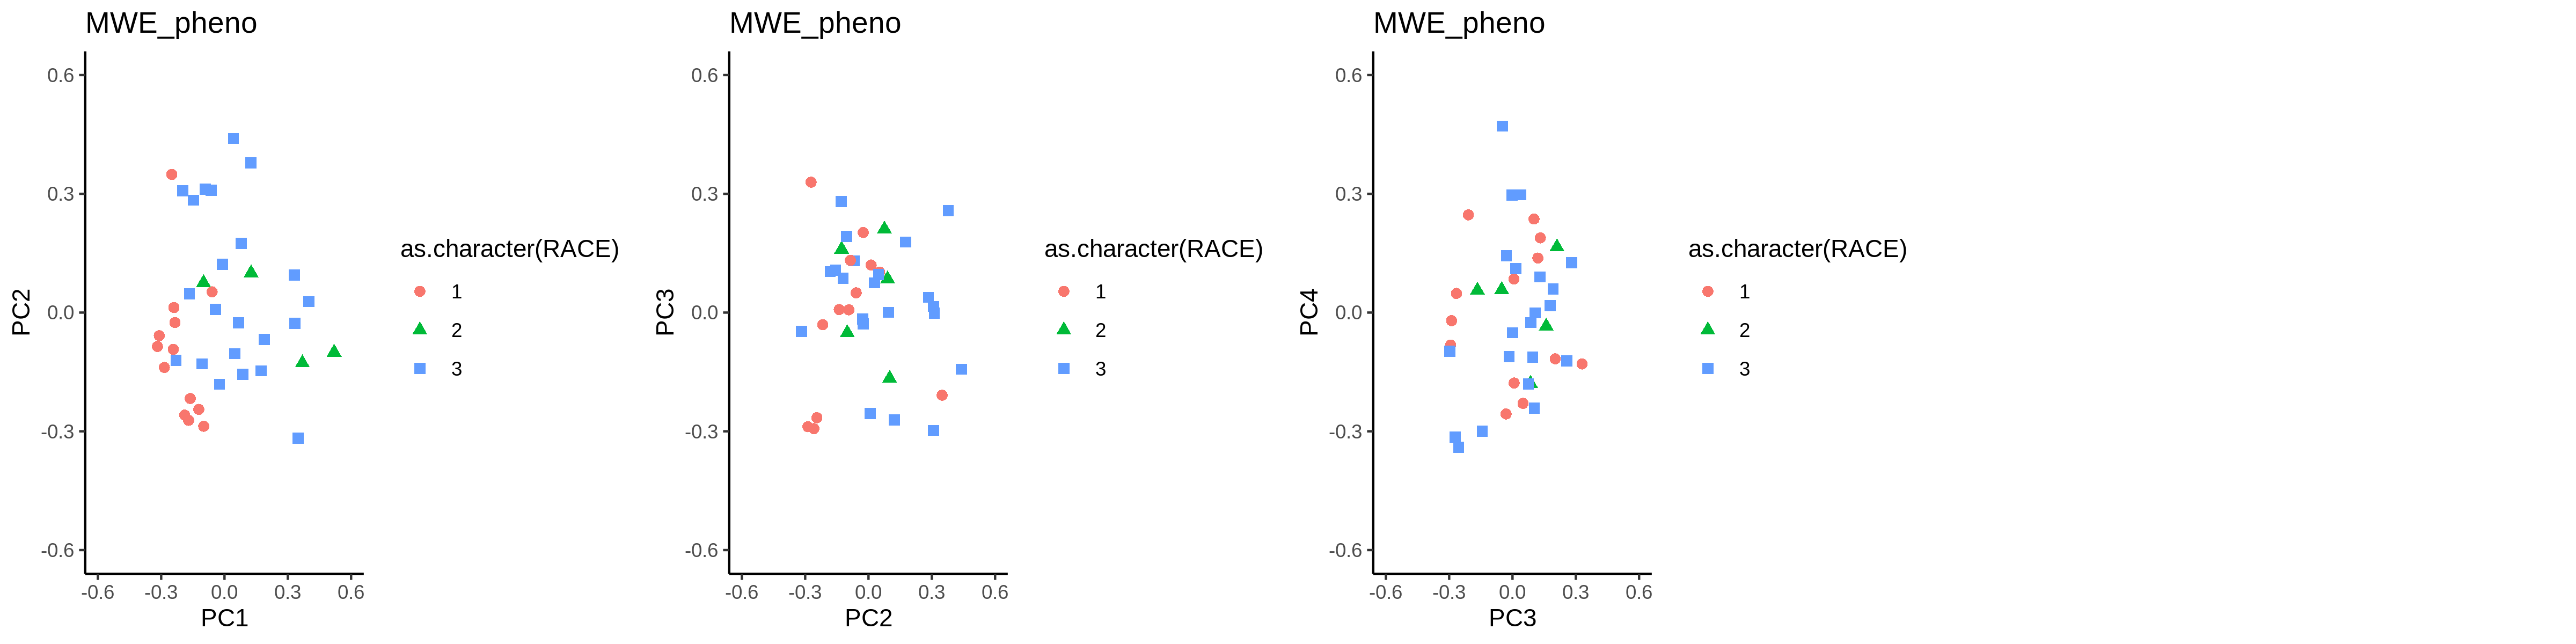

>>> /Users/dianacornejo/output/MWE_pheno.pca.pc.png:

bash: /Users/dianacornejo/output/MWE_pheno.pca.pc.png: Permission denied


In [35]:
%preview -s png  /Users/dianacornejo/output/MWE_pheno.pca.pc.png

### Step 5: Project back samples 

In [36]:
sos run  ~/bioworkflows/GWAS/PCA.ipynb project_samples \
    --cwd ~/output \
    --genoFile ~/output/cache/rename_chr22.related.filtered.bed \
    --phenoFile ~/MWE_AD/MWE_pheno.txt\
    --label_col RACE \
    --pca_model ~/output/MWE_pheno.pca.rds

INFO: Running project_samples_1: Project back to PCA model additional samples
HINT: Pulling docker image statisticalgenetics/lmm:1.8
HINT: Docker image statisticalgenetics/lmm:1.8 is now up to date
INFO: project_samples_1 is completed.
INFO: project_samples_1 output:   /Users/dianacornejo/MWE_AD/MWE_pheno.projected.rds
INFO: Running project_samples_2: 
INFO: project_samples_2 is completed (pending nested workflow).
INFO: Running detect_outliers: Calculate Mahalanobis distance per population and report outliers
INFO: detect_outliers is completed.
INFO: detect_outliers output:   /Users/dianacornejo/MWE_AD/MWE_pheno.projected.mahalanobis /Users/dianacornejo/MWE_AD/MWE_pheno.projected.no_outliers... (5 items)
INFO: project_samples_2 output:   /Users/dianacornejo/MWE_AD/MWE_pheno.projected.mahalanobis /Users/dianacornejo/MWE_AD/MWE_pheno.projected.no_outliers... (5 items)
INFO: Workflow project_samples (ID=wba505852aca6e884) is executed successfully with 3 completed steps.


## Step 6: Remove outliers from genofile for futher studies

In [39]:
sos run ~/bioworkflows/GWAS/GWAS_QC.ipynb qc:1 \
    --cwd ~/output \
    --keep-samples ~/MWE_AD/MWE_pheno.projected.no_outliers \
    --genoFile ~/MWE_AD/rename_chr22.bed \
    --name no_outliers

INFO: Running basic QC filters: Filter SNPs and select individuals
HINT: Pulling docker image statisticalgenetics/lmm:1.8
HINT: Docker image statisticalgenetics/lmm:1.8 is now up to date
INFO: basic QC filters is completed.
INFO: basic QC filters output:   /Users/dianacornejo/output/cache/rename_chr22.no_outliers.filtered.bed
INFO: Workflow qc (ID=we150def004c84bb9) is executed successfully with 1 completed step.
